### Korean Security Market

In [17]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

stock_list = pd.read_csv('stock_list.csv', index_col = 0)
stock_list.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,NaN,71300,2,-400,-0.56,71100,71400,70800,6988218,497101486200,425645495815000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,NaN,557000,2,-3000,-0.54,560000,563000,551000,251421,140379001000,130338000000000,234000000,STK
2,000660,KR7000660001,SK하이닉스,KOSPI,NaN,116700,2,-800,-0.68,116500,117300,115200,1352313,157092787800,84957875995500,728002365,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,NaN,734000,2,-7000,-0.94,739000,743000,730000,24105,17787925000,52241716000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,NaN,59600,2,-200,-0.33,59800,59900,59300,628228,37411700800,49044047320000,822886700,STK


In [18]:
code = stock_list['Code'][stock_list['Code'].str[-1] == '0']

In [35]:
import pandas_datareader as pdr
import datetime

data = pd.DataFrame()

start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2023, 11, 23)

for i in code :
    data = pd.concat(
        [data, 
        pdr.DataReader(i, "naver", start_date, end_date)['Close']], 
        axis = 1
    )
data.columns = code

In [36]:
data.dropna(axis = 1, inplace = True)
data = data.astype(int)
data.head()

Code,005930,000660,207940,051910,006400,005380,005490,003670,247540,000270,...,217320,121060,276240,217910,208890,266170,140660,288490,245450,308700
2020-01-02 00:00:00,55200,94700,423485,314000,232000,118000,236000,46320,13096,42500,...,10000,1570,518,345,800,1560,1650,387,1950,2015
2020-01-03 00:00:00,55500,94500,417061,311000,229000,116000,237000,46789,12675,42000,...,10000,1495,441,345,899,1465,1650,400,1950,2010
2020-01-06 00:00:00,55500,94300,407178,307000,230000,116000,231000,46742,12675,41900,...,10000,1395,459,345,899,1440,1645,440,1950,2100
2020-01-07 00:00:00,55800,94000,414096,311000,231500,115500,232000,47118,12923,42050,...,10000,1385,401,350,765,1425,1630,474,1800,2050
2020-01-08 00:00:00,56800,97400,403719,302000,229000,112000,228000,45100,12354,41300,...,10000,1480,459,350,765,1600,1630,483,2000,2050


In [37]:
ret_data = np.log(data / data.shift(1)).dropna()
ret_data.head()

Code,005930,000660,207940,051910,006400,005380,005490,003670,247540,000270,...,217320,121060,276240,217910,208890,266170,140660,288490,245450,308700
2020-01-03 00:00:00,0.005420,-0.002114,-0.015286,-0.009600,-0.013015,-0.017094,0.004228,0.010074,-0.032675,-0.011834,...,0.0,-0.048949,-0.160930,0.000000,0.116671,-0.062831,0.000000,0.033040,0.000000,-0.002484
2020-01-06 00:00:00,0.000000,-0.002119,-0.023982,-0.012945,0.004357,0.000000,-0.025642,-0.001005,0.000000,-0.002384,...,0.0,-0.069232,0.040005,0.000000,0.000000,-0.017212,-0.003035,0.095310,0.000000,0.043803
2020-01-07 00:00:00,0.005391,-0.003186,0.016847,0.012945,0.006501,-0.004320,0.004320,0.008012,0.019377,0.003574,...,0.0,-0.007194,-0.135089,0.014389,-0.161407,-0.010471,-0.009160,0.074433,-0.080043,-0.024098
2020-01-08 00:00:00,0.017762,0.035531,-0.025379,-0.029366,-0.010858,-0.030772,-0.017392,-0.043773,-0.045029,-0.017997,...,0.0,0.066342,0.135089,0.000000,0.000000,0.115832,0.000000,0.018809,0.105361,0.000000
2020-01-09 00:00:00,0.031198,0.016294,0.027764,0.014791,0.015168,-0.004474,0.025975,0.034776,0.104364,-0.013407,...,0.0,-0.129678,0.023682,0.000000,0.000000,0.054725,-0.018576,0.034591,0.000000,0.070618


<Axes: xlabel='Code', ylabel='Code'>

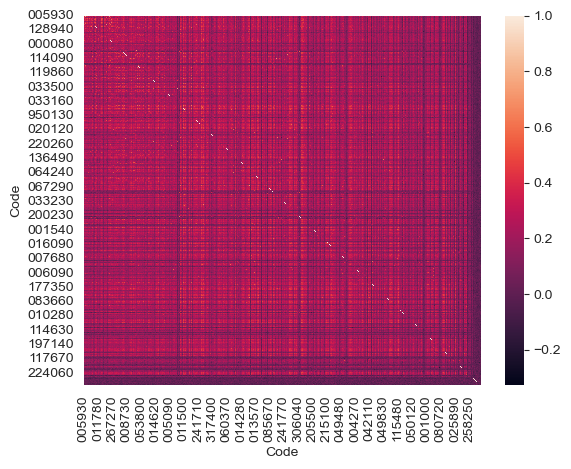

In [38]:
import seaborn as sns
sns.heatmap(ret_data.corr())

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
pca.fit(ret_data)

PCA(n_components=10)

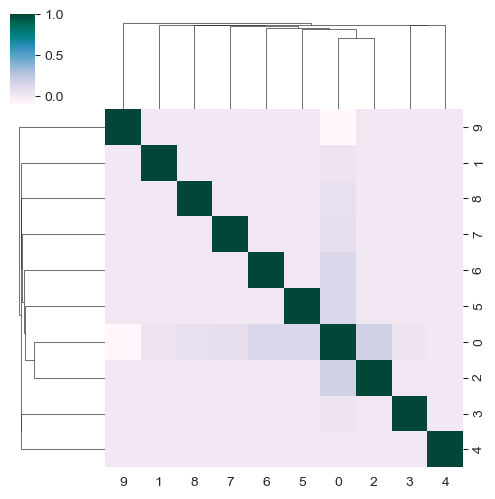

In [42]:
sns.clustermap(np.corrcoef(pca.components_), figsize = (5,5), cmap = 'PuBuGn')

In [43]:
from sklearn.cluster import KMeans

cov_matrix = ret_data.cov()

n_clusters = 10
kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
kmeans.fit(cov_matrix)

labels = kmeans.labels_

Text(0.5, 1.0, 'Mean-variance Clustering')

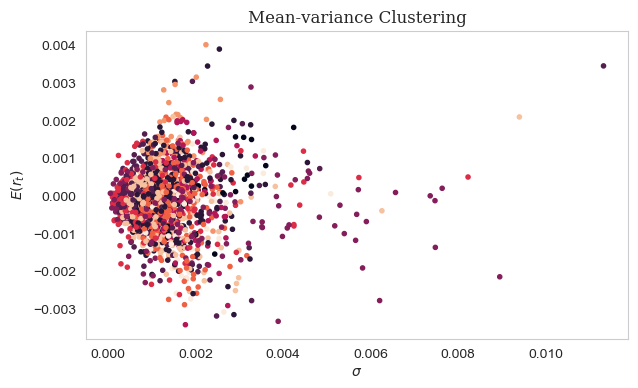

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize = (7,4))
plt.scatter(ret_data.var(axis = 0), ret_data.mean(axis = 0), c = labels, marker = '.')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$E(r_t)$')
plt.grid(False)
plt.title('Mean-variance Clustering', fontsize = 12, fontfamily = 'Serif')

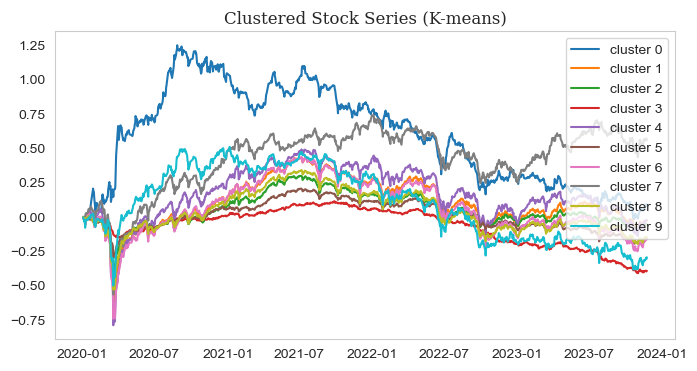

In [47]:
cluster_labels = pd.DataFrame({'cluster' : labels}, index = ret_data.columns)
plt.figure(figsize = (8, 4))
for i in range(10) :
    plt.plot(ret_data.loc[:, cluster_labels[cluster_labels['cluster'] == i].index].mean(axis = 1).cumsum(), label = 'cluster ' + str(i))
plt.grid(False)
plt.legend()
plt.title('Clustered Stock Series (K-means)', fontsize = 12, fontfamily = 'Serif')
plt.show()

In [76]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

correlation = ret_data.corr()
distances = np.sqrt((1 - correlation) / 2)
clusters = linkage(squareform(distances), method = "single")

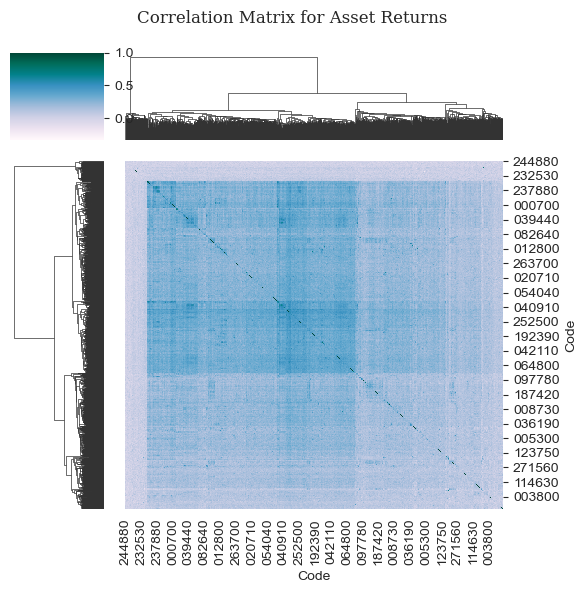

In [79]:
g = sns.clustermap(correlation, figsize = (6, 6), cmap = 'PuBuGn')
g.fig.suptitle('Correlation Matrix for Asset Returns', fontsize=12, fontfamily='Serif')
plt.tight_layout()
plt.show()

In [80]:
def QuasiDiag(link: np.ndarray) -> list:
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]    # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)    # make space
        df0 = sortIx[sortIx >= numItems]    # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]    # item 1
        df0 = pd.Series(link[j, 1], index=i+1)
        sortIx = pd.concat([sortIx, df0])    # item 2
        sortIx = sortIx.sort_index()    # re-sort
        sortIx.index = range(sortIx.shape[0])    # re-index
    lst =  sortIx.tolist()
    return lst

In [82]:
print(QuasiDiag(clusters)) # 준 대각화된 성분의 index

[2186, 2189, 2146, 2156, 2123, 2180, 2195, 1373, 2184, 2116, 2178, 2142, 2188, 2148, 2147, 2165, 2161, 2138, 2086, 2185, 2087, 2173, 1884, 2139, 2171, 2074, 2136, 2190, 2167, 2183, 2154, 2150, 1837, 1261, 2030, 2194, 2158, 2175, 2155, 2119, 1916, 1831, 2145, 2191, 2101, 2127, 1729, 2164, 1644, 2179, 2153, 2141, 2187, 2073, 2181, 1368, 2193, 2174, 2192, 1589, 2137, 1278, 922, 2070, 2159, 2177, 2168, 2162, 2072, 1334, 1029, 2170, 2157, 998, 2182, 958, 2051, 1992, 2169, 1700, 1592, 1853, 2031, 1671, 2133, 1454, 1663, 1731, 2135, 1885, 1846, 1519, 2029, 923, 2003, 1689, 1927, 1057, 2143, 709, 2102, 996, 1415, 2078, 1882, 1880, 259, 637, 2096, 1984, 1479, 1693, 2037, 1100, 1238, 904, 2091, 2166, 1156, 1023, 1381, 1871, 2083, 1175, 882, 833, 2122, 2027, 1499, 1041, 1716, 1081, 2151, 1414, 1084, 1453, 1921, 1271, 1762, 2149, 2125, 1157, 351, 2094, 2025, 909, 231, 1981, 378, 2140, 1917, 1115, 1165, 1529, 1940, 2082, 1570, 1053, 2109, 1949, 908, 2106, 1856, 734, 560, 2134, 2115, 1538, 526, 1723

In [81]:
def InversePortfolio(cov, **kargs) : 
    ivp = 1 / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def ClusterVar(cov, cItems) :
    cov_ = pd.DataFrame(cov).loc[cItems, cItems] # 행렬 분할
    w_ = InversePortfolio(cov_).reshape(-1, 1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
    return cVar

def RecBipart(cov: np.ndarray, sortIx: list) -> pd.Series:
    w = pd.Series([1] * len(sortIx), index=sortIx)
    cItems = [sortIx]    # 모든 아이템을 하나의 군집으로 초기화
    while len(cItems) > 0:
        cItems = [i[int(j): int(k)] for i in cItems
                  for j, k in ((0, len(i) / 2), (len(i) / 2, len(i))) if len(i) > 1]    # bi-section
        for i in range(0, len(cItems), 2):    # parse in pairs
            cItems0 = cItems[i]    # cluster 1
            cItems1 = cItems[i+1]    # cluster 2
            cVar0 = ClusterVar(cov, cItems0)
            cVar1 = ClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha    # weight 1
            w[cItems1] *= 1 - alpha    # weight 2
    return w

In [83]:
Ix = QuasiDiag(clusters)
weights = RecBipart(ret_data.cov().values, Ix)
weights.head()

2186    0.000687
2189    0.000679
2146    0.004615
2156    0.000633
2123    0.001005
dtype: float64